# Download data from kaggle

https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /content/kaggle.json

In [ ]:
! kaggle datasets download -d tolgadincer/labeled-chest-xray-images

# unziping data

In [ ]:
! unzip /content/labeled-chest-xray-images.zip

# import libraries

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, errno
from glob import glob
from PIL import Image
import shutil

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import model_selection


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator
import cv2 as cv


In [7]:
base_dir = "/content/chest_xray"
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"

In [8]:
train_NORMAL_dir=os.listdir("/content/chest_xray/train/NORMAL")
train_PNEUMONIA_dir=os.listdir("/content/chest_xray/train/PNEUMONIA")

In [9]:
print("Train set:\n______________")
print("Normal:", len(train_NORMAL_dir))
print("Pneumonia:", len(train_PNEUMONIA_dir))

Train set:
______________
Normal: 1349
Pneumonia: 3883


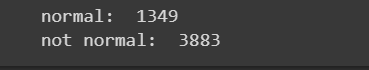

In [10]:
test_NORMAL_dir=os.listdir("/content/chest_xray/test/NORMAL")
test_PNEUMONIA_dir=os.listdir("/content/chest_xray/test/PNEUMONIA")

In [11]:
print("Test set:\n______________")
print("Normal:", len(test_NORMAL_dir))
print("Pneumonia:", len(test_PNEUMONIA_dir))

Test set:
______________
Normal: 234
Pneumonia: 390


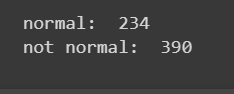

In [12]:
# train and test dataframe
train_df =pd.DataFrame(train_NORMAL_dir+train_PNEUMONIA_dir, columns=["path"])
train_df

,path
0,NORMAL-3860648-0002.jpeg
1,NORMAL-7140141-0003.jpeg
2,NORMAL-7274749-0001.jpeg
3,NORMAL-3194625-0001.jpeg
4,NORMAL-3342765-0001.jpeg
...,...
5227,BACTERIA-886684-0001.jpeg
5228,BACTERIA-9044719-0002.jpeg
5229,VIRUS-8144515-0001.jpeg
5230,VIRUS-8446523-0009.jpeg


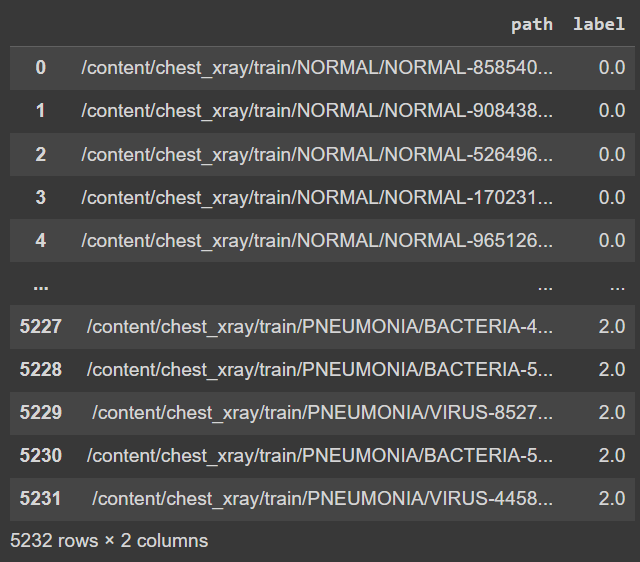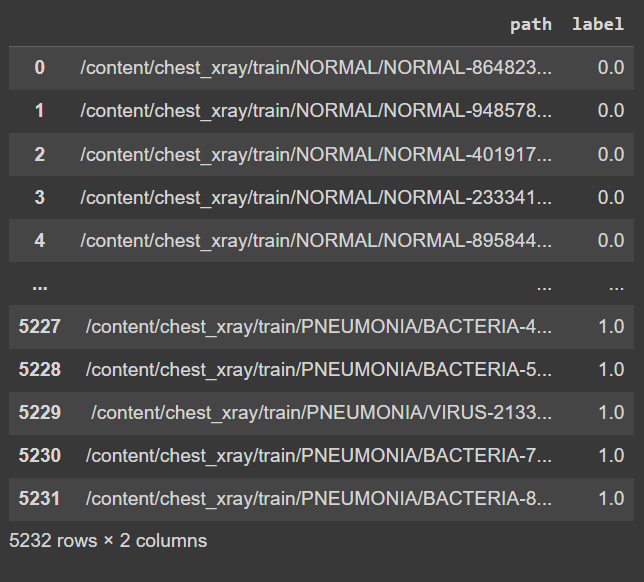

In [13]:
# test dataset
test_df =pd.DataFrame(test_NORMAL_dir+test_PNEUMONIA_dir, columns=["path"])
test_df

,path
0,NORMAL-8586608-0001.jpeg
1,NORMAL-520267-0001.jpeg
2,NORMAL-186900-0001.jpeg
3,NORMAL-9092354-0001.jpeg
4,NORMAL-71002-0001.jpeg
...,...
619,VIRUS-9890836-0001.jpeg
620,VIRUS-7822291-0001.jpeg
621,BACTERIA-1135262-0003.jpeg
622,VIRUS-6812602-0001.jpeg


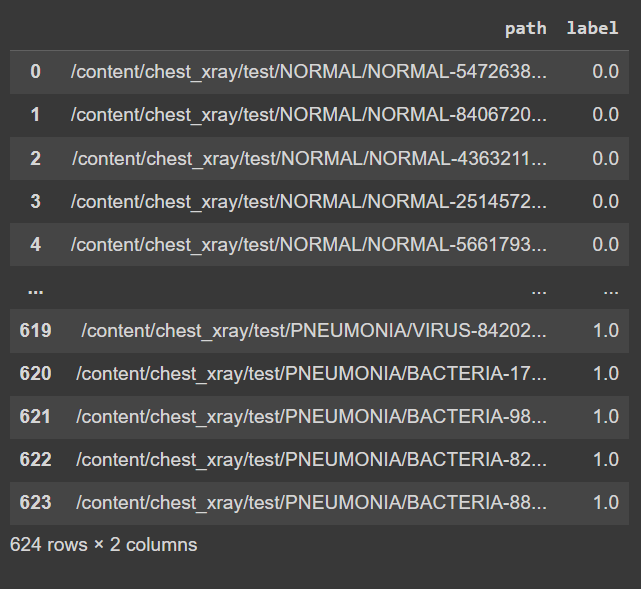

In [73]:
# Data augmentation function
train_data = ImageDataGenerator(
    validation_split=0.3,
    rescale=1.0/225,
    rotation_range=20,
    height_shift_range=0.1,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    vertical_flip=True)


test_data = ImageDataGenerator(rescale=1.0/225)

In [74]:
# The pipline
train = train_data.flow_from_directory(train_dir,
                                        batch_size=32,
                                        shuffle=True,
                                        class_mode='binary',
                                        target_size=(256, 256))

test = test_data.flow_from_directory(test_dir,
                                        batch_size=32,
                                        shuffle=True,
                                        class_mode='binary',
                                        target_size=(256, 256))

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
# train and test dataset
train_class = list(train.class_indices.keys())
train_data = {
    "path" : train.filenames,
    "label": [train_class[label] for label in train.classes]
             }
train_df = pd.DataFrame(train_data)
train_df



test_class = list(test.class_indices.keys())
test_data = {
    "path" : test.filenames,
    "label": [test_class[label] for label in test.classes]
             }
test_df = pd.DataFrame(test_data)
test_df

,path,label
0,NORMAL/NORMAL-1049278-0001.jpeg,NORMAL
1,NORMAL/NORMAL-1110860-0001.jpeg,NORMAL
2,NORMAL/NORMAL-11419-0001.jpeg,NORMAL
3,NORMAL/NORMAL-115218-0001.jpeg,NORMAL
4,NORMAL/NORMAL-1160949-0001.jpeg,NORMAL
...,...,...
619,PNEUMONIA/VIRUS-9584831-0001.jpeg,PNEUMONIA
620,PNEUMONIA/VIRUS-9671740-0001.jpeg,PNEUMONIA
621,PNEUMONIA/VIRUS-9783315-0001.jpeg,PNEUMONIA
622,PNEUMONIA/VIRUS-9890836-0001.jpeg,PNEUMONIA


# The model

In [75]:
# set random seed
tf.random.set_seed(42)

In [76]:
model = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation="leaky_relu"),
    layers.Dense(1, activation='sigmoid')

])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [78]:
history = model.fit(train, epochs=10, batch_size=32)

Epoch 1/10
164/164 [==============================] - 523s 3s/step - loss: 0.3590 - accuracy: 0.8427
Epoch 2/10
164/164 [==============================] - 524s 3s/step - loss: 0.2520 - accuracy: 0.8970
Epoch 3/10
164/164 [==============================] - 512s 3s/step - loss: 0.2325 - accuracy: 0.9050
Epoch 4/10
164/164 [==============================] - 517s 3s/step - loss: 0.2102 - accuracy: 0.9193
Epoch 5/10
164/164 [==============================] - 503s 3s/step - loss: 0.2049 - accuracy: 0.9205
Epoch 6/10
164/164 [==============================] - 514s 3s/step - loss: 0.1846 - accuracy: 0.9274
Epoch 7/10
164/164 [==============================] - 515s 3s/step - loss: 0.1602 - accuracy: 0.9390
Epoch 8/10
164/164 [==============================] - 513s 3s/step - loss: 0.1420 - accuracy: 0.9432
Epoch 9/10
164/164 [==============================] - 528s 3s/step - loss: 0.1465 - accuracy: 0.9432
Epoch 10/10
164/164 [==============================] - 519s 3s/step - loss: 0.1377 - accura

In [79]:
# history dataframe
history_df = pd.DataFrame(history.history)

Text(0.5, 1.0, 'Model loss')

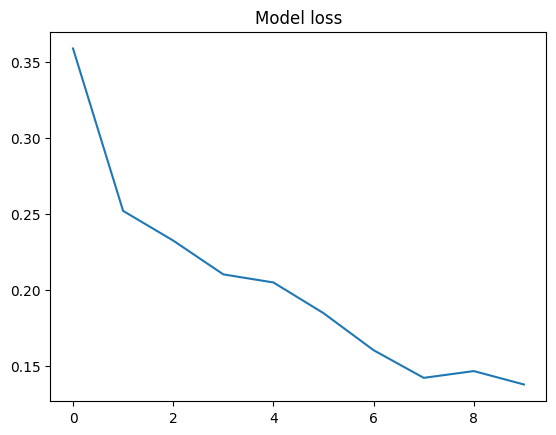

In [80]:
# plot history of loss
history_df['loss'].plot()
plt.title("Model loss")

Text(0.5, 1.0, 'Model accuracy')

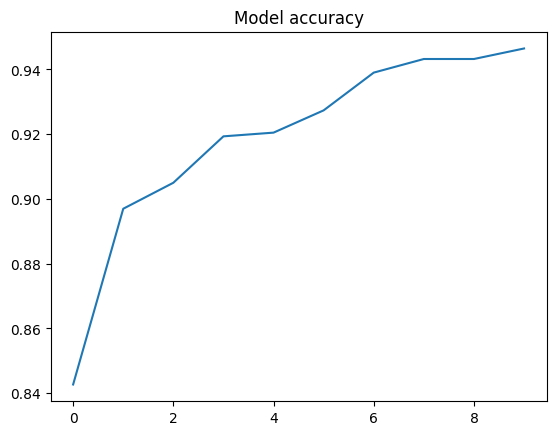

In [81]:
# plot history of accuracy
history_df['accuracy'].plot()
plt.title("Model accuracy")